In [4]:
import scipy.io as scio
import h5py
import tifffile as tf
from PIL import Image

import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

import networkx as nx
from networkx.algorithms import community
import powerlaw
import copy

from scipy import stats
from scipy.stats import pearsonr
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from itertools import chain
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

## Settings and Parameters

In [17]:
region_names = {64: 'MBPED',65: 'MBVL',66: 'MBML',55: 'LH',72: 'SLP',73: 'SIP',74: 'SMP',63: 'CRE',84: 'SCL',59: 'ICL',
                4: 'NO',23: 'EB',26: 'FB',56: 'LAL',79: 'AOTU',75: 'AVLP',76: 'PVLP',77: 'IVLP',60: 'VES',80: 'GOR',82: 'SPS',
                85: 'EPA',67: 'FLA'}
region_name_ids = {}
for k,v in region_names.items():
    region_name_ids[v] = k
print("region_names:", len(region_names), "region_name_ids:", len(region_name_ids))

focus_regions_0 = [64,65,66,55,72,73,74,63,84,59,4,23,26,56,79,75,76,77,60,80,82,85,67]

## path
path_prev = "xxxx/data_analysis_res/"
path_local ="xxxx/data_analysis_res_revision/"
path_inspur = "xxxx/olfactory_representation/"
print("path_prev:", path_prev)
print("path_local:", path_local)
print("path_inspur:", path_inspur)

## data
fly_idx_list = ['20230420-fly2', '20230510-fly2']

region_names: 23 region_name_ids: 23
path_prev: xxxx/data_analysis_res/
path_local: xxxx/data_analysis_res_revision/
path_inspur: xxxx/olfactory_representation/


# 01 Generate G7f brain network

## raw data

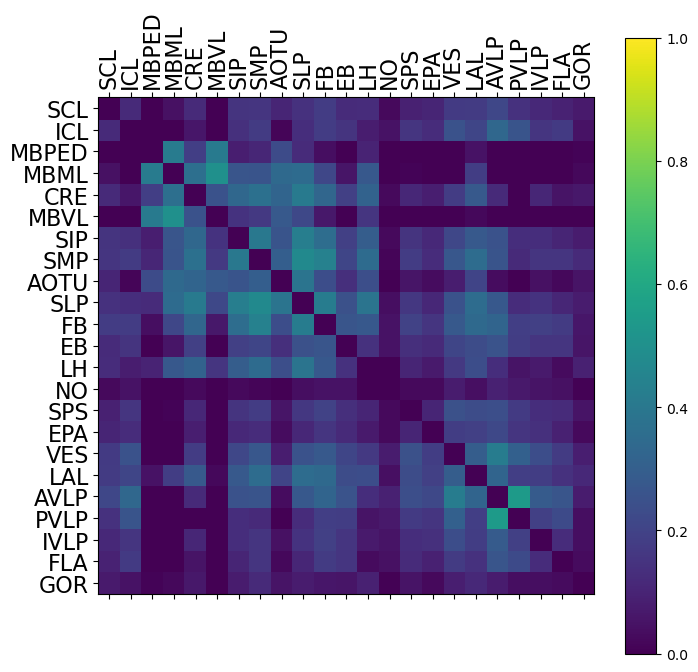

END


In [3]:
## output path
outpath = path_local + 'G7f-Ach_noise_ori_Stim/'

focus_regions = focus_regions_0
hierarchy_region_name = ['SCL', 'ICL', 'MBPED', 'MBML', 'CRE', 'MBVL', 'SIP', 'SMP', 'AOTU', 'SLP', 'FB', 'EB', 
                         'LH', 'NO', 'SPS', 'EPA', 'VES', 'LAL', 'AVLP', 'PVLP', 'IVLP', 'FLA', 'GOR']
hierarchy_region_0 = [region_name_ids[i] for i in hierarchy_region_name]
hierarchy_region = [i for i in hierarchy_region_0 if i in focus_regions]
calc_names = [region_names[i] for i in hierarchy_region]

n_regions = len(focus_regions_0)   
similarity = np.zeros((n_regions, n_regions))
for fly_idx in fly_idx_list:
    ## calculate
    inputpath = path_inspur + 'Ach-' + fly_idx + '-noise-stimu/'
    
    region_records_avg_dict = {}
    for region_idx in focus_regions:  
        ## load record data
        records = np.load(inputpath +'neuron_concat_records/region_' + str(region_idx) +'_neuron_records.npy',allow_pickle=True)

        ## select records for the given time period
        pre_sti = records[:, 3:23]
        frames = 20 
        duration = 23
        start_timepoint = 3 + duration
        len_max = len(records[0])
        while start_timepoint < len_max:
            pre_sti = np.concatenate((pre_sti,records[:, start_timepoint : start_timepoint + frames]), axis = 1) 
            start_timepoint += duration    

        ## generate average records
        pre_sti_avg = np.mean(pre_sti, axis = 0)
        region_records_avg_dict[region_idx] = pre_sti_avg

    ## calculate pearson correlation
    for i in range(n_regions - 1):
        for j in range(i + 1, n_regions):
            x, y = hierarchy_region[i], hierarchy_region[j]
            pearson = pearsonr(region_records_avg_dict[x], region_records_avg_dict[y])
            similarity[i,j] += pearson[0]
            similarity[j,i] += pearson[0]

similarity = similarity / 2
  
## plot
figure = plt.figure(figsize=(8,8)) 
axes = figure.add_subplot(111) 
caxes = axes.matshow(similarity, interpolation ='nearest', vmin = 0, vmax = 1) 
figure.colorbar(caxes) 
plt.xticks(rotation = 90, fontsize = 16)
plt.xticks(range(len(hierarchy_region)), calc_names)
plt.yticks(rotation = 0, fontsize = 16)
plt.yticks(range(len(hierarchy_region)), calc_names)
plt.savefig(outpath + 'both_fly_noise_all_regions_similarity_hierarchy2.pdf', dpi = 300, bbox_inches='tight')
plt.show()

## save data
np.save(outpath + 'both_fly_noise_all_regions_similarity_hierarchy2_region.npy', hierarchy_region)
np.save(outpath + 'both_fly_noise_all_regions_similarity_hierarchy2.npy', similarity)

print("END")

## denoise data

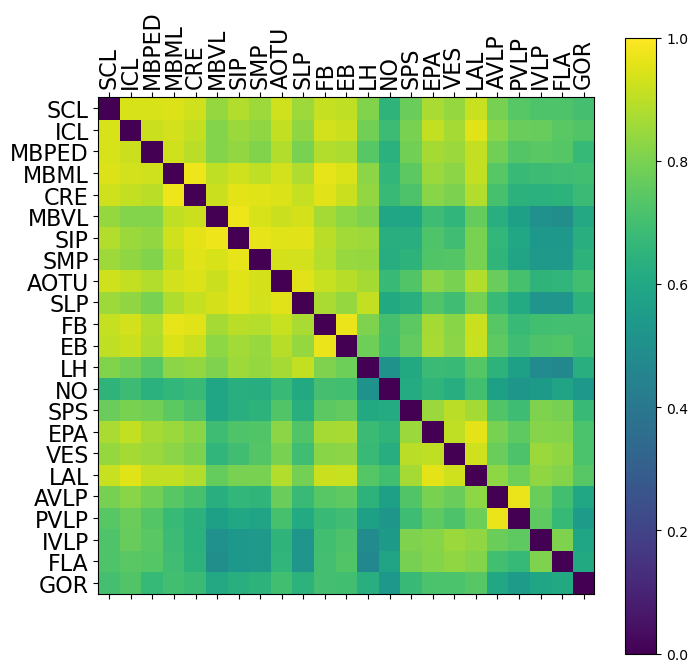

END


In [5]:
## output path
outpath = path_local + 'G7f-Ach_noise_ori_Stim/'

focus_regions = focus_regions_0
hierarchy_region_name = ['SCL', 'ICL', 'MBPED', 'MBML', 'CRE', 'MBVL', 'SIP', 'SMP', 'AOTU', 'SLP', 'FB', 'EB', 
                         'LH', 'NO', 'SPS', 'EPA', 'VES', 'LAL', 'AVLP', 'PVLP', 'IVLP', 'FLA', 'GOR']
hierarchy_region_0 = [region_name_ids[i] for i in hierarchy_region_name]
hierarchy_region = [i for i in hierarchy_region_0 if i in focus_regions]
calc_names = [region_names[i] for i in hierarchy_region]

n_regions = len(focus_regions_0)   
similarity = np.zeros((n_regions, n_regions))
for fly_idx in fly_idx_list:
    ## calculate
    inputpath = path_inspur + 'Ach-' + fly_idx + '-stimu/'
    
    region_records_avg_dict = {}
    for region_idx in focus_regions:  
        ## load record data
        records = np.load(inputpath +'neuron_concat_records/region_' + str(region_idx) +'_neuron_records.npy',allow_pickle=True)

        ## select records for the given time period
        pre_sti = records[:, 3:23]
        frames = 20 
        duration = 23
        start_timepoint = 3 + duration
        len_max = len(records[0])
        while start_timepoint < len_max:
            pre_sti = np.concatenate((pre_sti,records[:, start_timepoint : start_timepoint + frames]), axis = 1) 
            start_timepoint += duration    

        ## generate average records
        pre_sti_avg = np.mean(pre_sti, axis = 0)
        region_records_avg_dict[region_idx] = pre_sti_avg

    ## calculate pearson correlation
    for i in range(n_regions - 1):
        for j in range(i + 1, n_regions):
            x, y = hierarchy_region[i], hierarchy_region[j]
            pearson = pearsonr(region_records_avg_dict[x], region_records_avg_dict[y])
            similarity[i,j] += pearson[0]
            similarity[j,i] += pearson[0]

similarity = similarity / 2
  
## plot
figure = plt.figure(figsize=(8,8)) 
axes = figure.add_subplot(111) 
caxes = axes.matshow(similarity, interpolation ='nearest', vmin = 0, vmax = 1) 
figure.colorbar(caxes) 
plt.xticks(rotation = 90, fontsize = 16)
plt.xticks(range(len(hierarchy_region)), calc_names)
plt.yticks(rotation = 0, fontsize = 16)
plt.yticks(range(len(hierarchy_region)), calc_names)
plt.savefig(outpath + 'both_fly_ori_all_regions_similarity_hierarchy2.pdf', dpi = 300, bbox_inches='tight')
plt.show()

## save data
np.save(outpath + 'both_fly_ori_all_regions_similarity_hierarchy2_region.npy', hierarchy_region)
np.save(outpath + 'both_fly_ori_all_regions_similarity_hierarchy2.npy', similarity)

print("END")

## compare denoise and raw data

noise_list: 253 denoise_list: 253


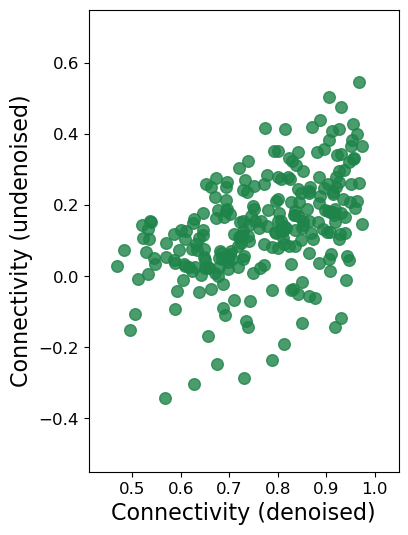

pearson: PearsonRResult(statistic=0.4599949807638126, pvalue=1.1878434019614397e-14)


In [8]:
def normalization(data):
    _range = np.max(data) - np.min(data)
    return (data - np.min(data)) / _range

## output path
outpath = path_local + 'G7f-Ach_noise_ori_Stim/'

hierarchy_region_noise = np.load(outpath + 'both_fly_noise_all_regions_similarity_hierarchy2_region.npy')
similarity_noise = np.load(outpath + 'both_fly_noise_all_regions_similarity_hierarchy2.npy')

hierarchy_region_denoise = np.load(outpath + 'both_fly_ori_all_regions_similarity_hierarchy2_region.npy')
similarity_denoise = np.load(outpath + 'both_fly_ori_all_regions_similarity_hierarchy2.npy')

noise_list, denoise_list = [], []
n_regions = len(similarity_noise)
for i in range(n_regions - 1):
    for j in range(i + 1, n_regions):
        noise_list.append(similarity_noise[i,j])
        denoise_list.append(similarity_denoise[i,j])
print("noise_list:", len(noise_list), "denoise_list:", len(denoise_list))

fig,ax = plt.subplots(figsize=(4,6),dpi=100,facecolor="w")
plt.scatter(denoise_list, noise_list, s = 70, c = "#1E8449", alpha = 0.8)
plt.xlabel("Connectivity (denoised)", fontsize = 16)
plt.ylabel("Connectivity (undenoised)", fontsize = 16)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.xlim(0.41, 1.05)
plt.ylim(-0.55, 0.75)
plt.savefig(outpath + "both_fly_noise_vs_ori_all_regions_similarity_hierarchy2_region.pdf", bbox_inches='tight')
plt.show()

pearson = pearsonr(denoise_list, noise_list)
print("pearson:", pearson)


## generate brain-region-level network

In [78]:
## output path
outpath = path_local + 'G7f-Ach_noise_ori_Stim/'
print("outpath:", outpath)

'''
noise
'''
similarity = np.load(outpath + 'both_fly_noise_all_regions_similarity_hierarchy2.npy')
print("similarity:", type(similarity), similarity.shape)

## keep only correlations with high positive values 
delete_seg = 0
weighted_edges_list = similarity.flatten()
weighted_edges_list.sort()
threshold = weighted_edges_list[int(delete_seg * len(weighted_edges_list))]

## generate network from correlation matrix
focus_regions = focus_regions_0
nodes = [i for i in range(len(focus_regions_0)) if focus_regions_0[i] in focus_regions]
weighted_edges = [] 
source = []
target = []
weight = []
n_neurons = len(nodes)
for i in range(n_neurons - 1):
    for j in range(i + 1, n_neurons):
        x, y = nodes[i], nodes[j]
        v = similarity[i,j]
        if v < threshold:
            continue
        weighted_edges.append(np.array([x, y, np.round(v,4)]))
        source.append(x)
        target.append(y)
        weight.append(np.round(v,4))
print("finish generating network ...")
print("# original edges: ", len(weighted_edges_list), ", # preserved edges:", len(weighted_edges))

## save network into csv files
save_data_calc = {"source": source, "target": target, "weight": weight}
df = pd.DataFrame(save_data_calc)
df.to_csv(outpath + 'noise_calc_regions_of_whole_brain_network_edges' + str(round(1 - delete_seg, 1)) + '.csv', index=False)

'''
denoise
'''
similarity = np.load(outpath + 'both_fly_ori_all_regions_similarity_hierarchy2.npy')
print("similarity:", type(similarity), similarity.shape)

## keep only correlations with high positive values 
delete_seg = 0
weighted_edges_list = similarity.flatten()
weighted_edges_list.sort()
threshold = weighted_edges_list[int(delete_seg * len(weighted_edges_list))]

## generate network from correlation matrix
focus_regions = focus_regions_0
nodes = [i for i in range(len(focus_regions_0)) if focus_regions_0[i] in focus_regions]
weighted_edges = [] 
source = []
target = []
weight = []
n_neurons = len(nodes)
for i in range(n_neurons - 1):
    for j in range(i + 1, n_neurons):
        x, y = nodes[i], nodes[j]
        v = similarity[i,j]
        if v < threshold:
            continue
        weighted_edges.append(np.array([x, y, np.round(v,4)]))
        source.append(x)
        target.append(y)
        weight.append(np.round(v,4))
print("finish generating network ...")
print("# original edges: ", len(weighted_edges_list), ", # preserved edges:", len(weighted_edges))

## save network into csv files
save_data_calc = {"source": source, "target": target, "weight": weight}
df = pd.DataFrame(save_data_calc)
df.to_csv(outpath + 'denoise_calc_regions_of_whole_brain_network_edges' + str(round(1 - delete_seg, 1)) + '.csv', index=False)

print("end")

outpath: F:/THU/drosophila multi-probes/data_analysis_res_revision/G7f-Ach_noise_ori_Stim/
similarity: <class 'numpy.ndarray'> (23, 23)
finish generating network ...
# original edges:  529 , # preserved edges: 253
similarity: <class 'numpy.ndarray'> (23, 23)
finish generating network ...
# original edges:  529 , # preserved edges: 253
end


# 02 generate Ach brain network

## raw data

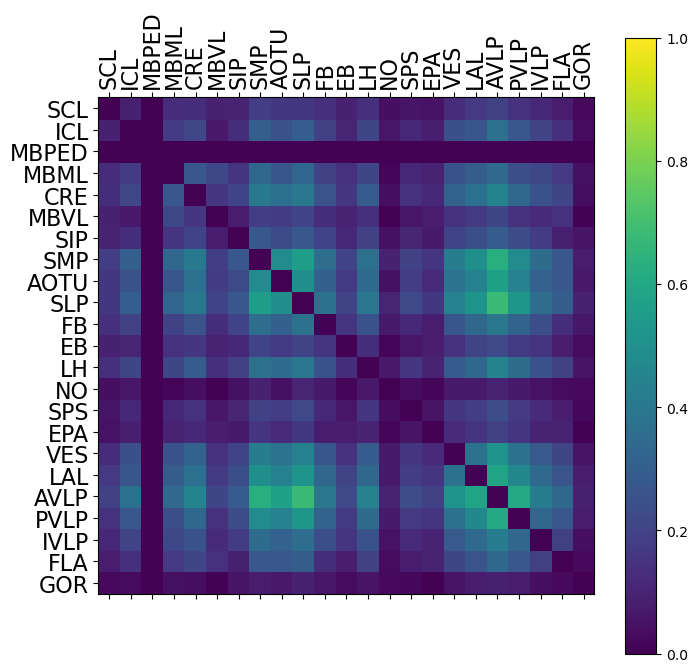

END


In [10]:
## output path
outpath = path_local + 'G7f-Ach_noise_ori_Stim/'

focus_regions = focus_regions_0
hierarchy_region_name = ['SCL', 'ICL', 'MBPED', 'MBML', 'CRE', 'MBVL', 'SIP', 'SMP', 'AOTU', 'SLP', 'FB', 'EB', 
                         'LH', 'NO', 'SPS', 'EPA', 'VES', 'LAL', 'AVLP', 'PVLP', 'IVLP', 'FLA', 'GOR']
hierarchy_region_0 = [region_name_ids[i] for i in hierarchy_region_name]
hierarchy_region = [i for i in hierarchy_region_0 if i in focus_regions]
calc_names = [region_names[i] for i in hierarchy_region]

n_regions = len(focus_regions_0)   
similarity = np.zeros((n_regions, n_regions))
for fly_idx in fly_idx_list:
    ## calculate
    inputpath = path_inspur + 'Ach-' + fly_idx + '-noise-trans-stimu/'
    
    region_records_avg_dict = {}
    for region_idx in focus_regions:  
        ## load record data
        records = np.load(inputpath +'neuron_concat_records/region_' + str(region_idx) +'_neuron_records.npy',allow_pickle=True)

        ## select records for the given time period
        pre_sti = records[:, 3:23]
        frames = 20 
        duration = 23
        start_timepoint = 3 + duration
        len_max = len(records[0])
        while start_timepoint < len_max:
            pre_sti = np.concatenate((pre_sti,records[:, start_timepoint : start_timepoint + frames]), axis = 1) 
            start_timepoint += duration    

        ## generate average records
        pre_sti_avg = np.mean(pre_sti, axis = 0)
        region_records_avg_dict[region_idx] = pre_sti_avg

    ## calculate pearson correlation
    for i in range(n_regions - 1):
        for j in range(i + 1, n_regions):
            x, y = hierarchy_region[i], hierarchy_region[j]
            pearson = pearsonr(region_records_avg_dict[x], region_records_avg_dict[y])
            similarity[i,j] += pearson[0]
            similarity[j,i] += pearson[0]

similarity = similarity / 2
  
## plot
figure = plt.figure(figsize=(8,8)) 
axes = figure.add_subplot(111) 
caxes = axes.matshow(similarity, interpolation ='nearest', vmin = 0, vmax = 1) 
figure.colorbar(caxes) 
plt.xticks(rotation = 90, fontsize = 16)
plt.xticks(range(len(hierarchy_region)), calc_names)
plt.yticks(rotation = 0, fontsize = 16)
plt.yticks(range(len(hierarchy_region)), calc_names)
plt.savefig(outpath + 'both_fly_ach_noise_all_regions_similarity_hierarchy2.pdf', dpi = 300, bbox_inches='tight')
plt.show()

## save data
np.save(outpath + 'both_fly_ach_noise_all_regions_similarity_hierarchy2_region.npy', hierarchy_region)
np.save(outpath + 'both_fly_ach_noise_all_regions_similarity_hierarchy2.npy', similarity)

print("END")

## denoise data

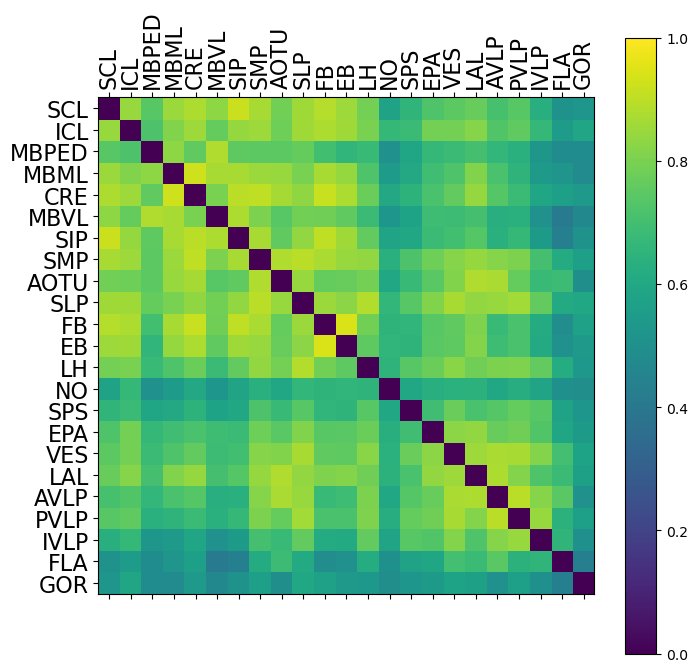

END


In [11]:
## output path
outpath = path_local + 'G7f-Ach_noise_ori_Stim/'

focus_regions = focus_regions_0
hierarchy_region_name = ['SCL', 'ICL', 'MBPED', 'MBML', 'CRE', 'MBVL', 'SIP', 'SMP', 'AOTU', 'SLP', 'FB', 'EB', 
                         'LH', 'NO', 'SPS', 'EPA', 'VES', 'LAL', 'AVLP', 'PVLP', 'IVLP', 'FLA', 'GOR']
hierarchy_region_0 = [region_name_ids[i] for i in hierarchy_region_name]
hierarchy_region = [i for i in hierarchy_region_0 if i in focus_regions]
calc_names = [region_names[i] for i in hierarchy_region]

n_regions = len(focus_regions_0)   
similarity = np.zeros((n_regions, n_regions))
for fly_idx in fly_idx_list:
    ## calculate
    inputpath = path_inspur + 'Ach-' + fly_idx + '-trans-stimu/'
    
    region_records_avg_dict = {}
    for region_idx in focus_regions:  
        ## load record data
        records = np.load(inputpath +'neuron_concat_records/region_' + str(region_idx) +'_neuron_records.npy',allow_pickle=True)

        ## select records for the given time period
        pre_sti = records[:, 3:23]
        frames = 20 
        duration = 23
        start_timepoint = 3 + duration
        len_max = len(records[0])
        while start_timepoint < len_max:
            pre_sti = np.concatenate((pre_sti,records[:, start_timepoint : start_timepoint + frames]), axis = 1) 
            start_timepoint += duration    

        ## generate average records
        pre_sti_avg = np.mean(pre_sti, axis = 0)
        region_records_avg_dict[region_idx] = pre_sti_avg

    ## calculate pearson correlation
    for i in range(n_regions - 1):
        for j in range(i + 1, n_regions):
            x, y = hierarchy_region[i], hierarchy_region[j]
            pearson = pearsonr(region_records_avg_dict[x], region_records_avg_dict[y])
            similarity[i,j] += pearson[0]
            similarity[j,i] += pearson[0]

similarity = similarity / 2
  
## plot
figure = plt.figure(figsize=(8,8)) 
axes = figure.add_subplot(111) 
caxes = axes.matshow(similarity, interpolation ='nearest', vmin = 0, vmax = 1) 
figure.colorbar(caxes) 
plt.xticks(rotation = 90, fontsize = 16)
plt.xticks(range(len(hierarchy_region)), calc_names)
plt.yticks(rotation = 0, fontsize = 16)
plt.yticks(range(len(hierarchy_region)), calc_names)
plt.savefig(outpath + 'both_fly_ach_ori_all_regions_similarity_hierarchy2.pdf', dpi = 300, bbox_inches='tight')
plt.show()

## save data
np.save(outpath + 'both_fly_ach_ori_all_regions_similarity_hierarchy2_region.npy', hierarchy_region)
np.save(outpath + 'both_fly_ach_ori_all_regions_similarity_hierarchy2.npy', similarity)

print("END")

## compare denoise and noise data

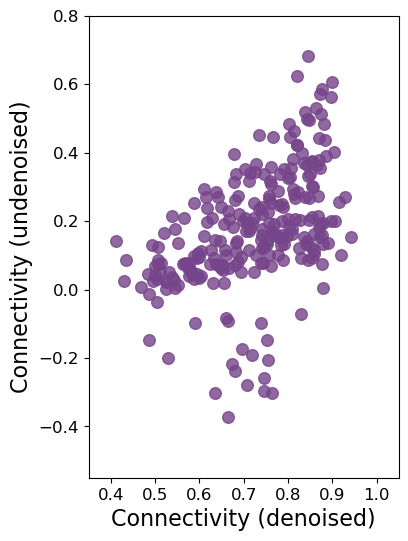

pearson: PearsonRResult(statistic=0.48429101091800303, pvalue=2.776912753280829e-16)


In [12]:
hierarchy_region_noise = np.load(outpath + 'both_fly_ach_noise_all_regions_similarity_hierarchy2_region.npy')
similarity_noise = np.load(outpath + 'both_fly_ach_noise_all_regions_similarity_hierarchy2.npy')

hierarchy_region_denoise = np.load(outpath + 'both_fly_ach_ori_all_regions_similarity_hierarchy2_region.npy')
similarity_denoise = np.load(outpath + 'both_fly_ach_ori_all_regions_similarity_hierarchy2.npy')

noise_list, denoise_list = [], []
n_regions = len(similarity_noise)
for i in range(n_regions - 1):
    for j in range(i + 1, n_regions):
        noise_list.append(similarity_noise[i,j])
        denoise_list.append(similarity_denoise[i,j])

coeff = np.polyfit(denoise_list, noise_list, 1)
p_burst = np.poly1d(coeff)
corr = np.corrcoef(noise_list, p_burst(denoise_list))[0,1]

fig,ax = plt.subplots(figsize=(4,6),dpi=100,facecolor="w")
plt.scatter(denoise_list, noise_list, s = 70, c = "#76448A", alpha = 0.8)
# plt.plot(denoise_list, p_burst(denoise_list), color = "#34495E", linewidth = 1)
plt.xlabel("Connectivity (denoised)", fontsize = 16)
plt.ylabel("Connectivity (undenoised)", fontsize = 16)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.xlim(0.35, 1.05)
plt.ylim(-0.55, 0.8)
plt.savefig(outpath + "both_fly_ach_noise_vs_ori_all_regions_similarity_hierarchy2_region.pdf", bbox_inches='tight')
plt.show()

pearson = pearsonr(denoise_list, noise_list)
print("pearson:", pearson)

## generate brain-region-level network

In [79]:
## output path
outpath = path_local + 'G7f-Ach_noise_ori_Stim/'
print("outpath:", outpath)

'''
noise
'''
similarity = np.load(outpath + 'both_fly_ach_noise_all_regions_similarity_hierarchy2.npy')
print("similarity:", type(similarity), similarity.shape)

## keep only correlations with high positive values 
delete_seg = 0
weighted_edges_list = similarity.flatten()
weighted_edges_list.sort()
threshold = weighted_edges_list[int(delete_seg * len(weighted_edges_list))]

## generate network from correlation matrix
focus_regions = focus_regions_0
nodes = [i for i in range(len(focus_regions_0)) if focus_regions_0[i] in focus_regions]
weighted_edges = [] 
source = []
target = []
weight = []
n_neurons = len(nodes)
for i in range(n_neurons - 1):
    for j in range(i + 1, n_neurons):
        x, y = nodes[i], nodes[j]
        v = similarity[i,j]
        if v < threshold:
            continue
        weighted_edges.append(np.array([x, y, np.round(v,4)]))
        source.append(x)
        target.append(y)
        weight.append(np.round(v,4))
print("finish generating network ...")
print("# original edges: ", len(weighted_edges_list), ", # preserved edges:", len(weighted_edges))

## save network into csv files
save_data_calc = {"source": source, "target": target, "weight": weight}
df = pd.DataFrame(save_data_calc)
df.to_csv(outpath + 'noise_ach_regions_of_whole_brain_network_edges' + str(round(1 - delete_seg, 1)) + '.csv', index=False)

'''
denoise
'''
similarity = np.load(outpath + 'both_fly_ach_ori_all_regions_similarity_hierarchy2.npy')
print("similarity:", type(similarity), similarity.shape)

## keep only correlations with high positive values 
delete_seg = 0
weighted_edges_list = similarity.flatten()
weighted_edges_list.sort()
threshold = weighted_edges_list[int(delete_seg * len(weighted_edges_list))]

## generate network from correlation matrix
focus_regions = focus_regions_0
nodes = [i for i in range(len(focus_regions_0)) if focus_regions_0[i] in focus_regions]
weighted_edges = [] 
source = []
target = []
weight = []
n_neurons = len(nodes)
for i in range(n_neurons - 1):
    for j in range(i + 1, n_neurons):
        x, y = nodes[i], nodes[j]
        v = similarity[i,j]
        if v < threshold:
            continue
        weighted_edges.append(np.array([x, y, np.round(v,4)]))
        source.append(x)
        target.append(y)
        weight.append(np.round(v,4))
print("finish generating network ...")
print("# original edges: ", len(weighted_edges_list), ", # preserved edges:", len(weighted_edges))

## save network into csv files
save_data_calc = {"source": source, "target": target, "weight": weight}
df = pd.DataFrame(save_data_calc)
df.to_csv(outpath + 'denoise_ach_regions_of_whole_brain_network_edges' + str(round(1 - delete_seg, 1)) + '.csv', index=False)

print("end")

outpath: F:/THU/drosophila multi-probes/data_analysis_res_revision/G7f-Ach_noise_ori_Stim/
similarity: <class 'numpy.ndarray'> (23, 23)
finish generating network ...
# original edges:  529 , # preserved edges: 253
similarity: <class 'numpy.ndarray'> (23, 23)
finish generating network ...
# original edges:  529 , # preserved edges: 253
end


# Statistics of the whole-brain-level functional networks

outpath: F:/THU/drosophila multi-probes/data_analysis_res_revision/G7f-Ach_noise_ori_Stim/


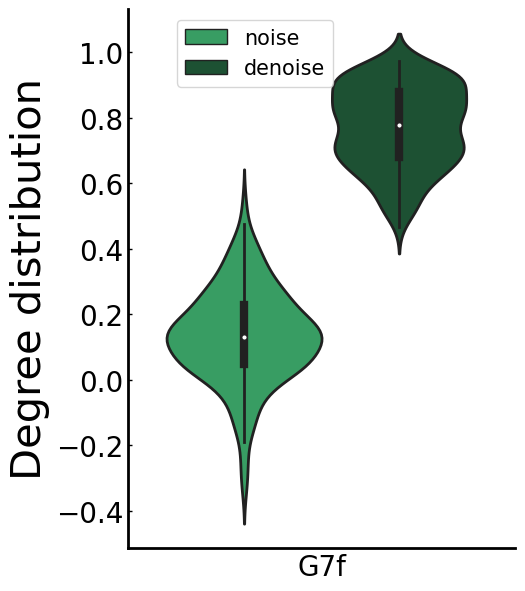

>>>> Testing between noise and denoise
------- G7f --------
ks_2samp stat: 0.9881422924901185  p value: 5.779937467703977e-144


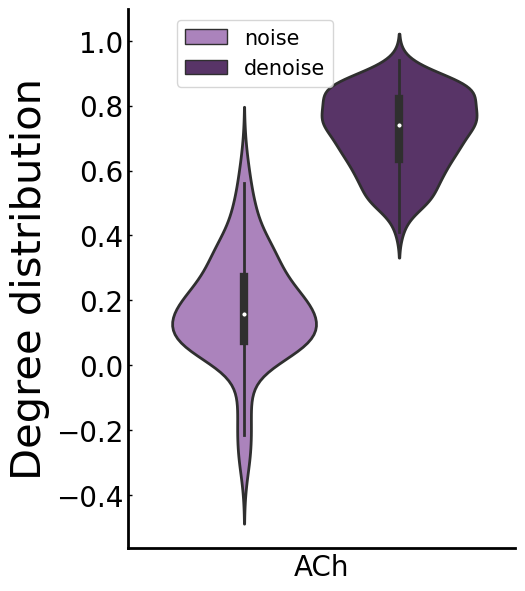

>>>> Testing between noise and denoise
------- ACh --------
ks_2samp stat: 0.9407114624505929  p value: 6.094896499588695e-123


In [13]:
## path
outpath = path_local + 'G7f-Ach_noise_ori_Stim/'
print("outpath:", outpath)

'''g7f'''
hierarchy_region_noise = np.load(outpath + 'both_fly_noise_all_regions_similarity_hierarchy2_region.npy')
similarity_noise = np.load(outpath + 'both_fly_noise_all_regions_similarity_hierarchy2.npy')

hierarchy_region_denoise = np.load(outpath + 'both_fly_ori_all_regions_similarity_hierarchy2_region.npy')
similarity_denoise = np.load(outpath + 'both_fly_ori_all_regions_similarity_hierarchy2.npy')

noise_list, denoise_list = [], []
n_regions = len(similarity_noise)
for i in range(n_regions - 1):
    for j in range(i + 1, n_regions):
        noise_list.append(similarity_noise[i,j])
        denoise_list.append(similarity_denoise[i,j])

stage_names = ['G7f']
indicators = ['noise', 'denoise']

x = [stage_names[0]] * len(noise_list) * 2  
hue = [indicators[0]] * len(noise_list) + [indicators[1]] * len(denoise_list) 
data_flatten = list(noise_list) + list(denoise_list)  

## plot
fig,ax = plt.subplots(figsize=(5,7),dpi=100,facecolor="w")
ax = sns.violinplot(x = x, y = data_flatten, hue = hue, order = stage_names, ax = ax, palette= ["#27AE60","#145A32"],
                    width=0.8, linewidth=2, notch=False, alpha =0.3)
ax.legend(bbox_to_anchor=(0.1,0.1,1.01,0.9), fontsize = 15)
ax.tick_params(which='major',direction='in',length=3,width=1.,labelsize=20,bottom=False)
for spine in ["top","right"]:
    ax.spines[spine].set_visible(False)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.set_axisbelow(True)
# ax.set_ylim([-1,30])
ax.set_ylabel("Degree distribution", fontsize = 30)
plt.savefig(outpath + 'both_fly_node_degree_dist_noise_denoise_g7f_violin.pdf', dpi = 300, bbox_inches='tight')
plt.show()

## test
alternative='two-sided'
mode='auto'

print(">>>> Testing between noise and denoise")
print("------- G7f --------")
stat, p_vlaue = stats.ks_2samp(noise_list, denoise_list, alternative=alternative, mode=mode)
print("ks_2samp stat:", stat, " p value:", p_vlaue)



'''ach'''
hierarchy_region_noise = np.load(outpath + 'both_fly_ach_noise_all_regions_similarity_hierarchy2_region.npy')
similarity_noise = np.load(outpath + 'both_fly_ach_noise_all_regions_similarity_hierarchy2.npy')

hierarchy_region_denoise = np.load(outpath + 'both_fly_ach_ori_all_regions_similarity_hierarchy2_region.npy')
similarity_denoise = np.load(outpath + 'both_fly_ach_ori_all_regions_similarity_hierarchy2.npy')

noise_list, denoise_list = [], []
n_regions = len(similarity_noise)
for i in range(n_regions - 1):
    for j in range(i + 1, n_regions):
        noise_list.append(similarity_noise[i,j])
        denoise_list.append(similarity_denoise[i,j])

stage_names = ['ACh']
indicators = ['noise', 'denoise']

x = [stage_names[0]] * len(noise_list) * 2  
hue = [indicators[0]] * len(noise_list) + [indicators[1]] * len(denoise_list) 
data_flatten = list(noise_list) + list(denoise_list)  

## plot
fig,ax = plt.subplots(figsize=(5,7),dpi=100,facecolor="w")
ax = sns.violinplot(x = x, y = data_flatten, hue = hue, order = stage_names, ax = ax, palette= ["#AF7AC5","#5B2C6F"],
                    width=0.8, linewidth=2, notch=False, alpha =0.3)
ax.legend(bbox_to_anchor=(0.1,0.1,1.01,0.9), fontsize = 15)
ax.tick_params(which='major',direction='in',length=3,width=1.,labelsize=20,bottom=False)
for spine in ["top","right"]:
    ax.spines[spine].set_visible(False)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.set_axisbelow(True)
# ax.set_ylim([-1,30])
ax.set_ylabel("Degree distribution", fontsize = 30)
plt.savefig(outpath + 'both_fly_node_degree_dist_noise_denoise_ach_violin.pdf', dpi = 300, bbox_inches='tight')
plt.show()

## test
alternative='two-sided'
mode='auto'

print(">>>> Testing between noise and denoise")
print("------- ACh --------")
stat, p_vlaue = stats.ks_2samp(noise_list, denoise_list, alternative=alternative, mode=mode)
print("ks_2samp stat:", stat, " p value:", p_vlaue)


In [16]:
## path
outpath = path_local + 'G7f-Ach_noise_ori_Stim/'

hierarchy_region_name = ['SCL', 'ICL', 'MBPED', 'MBML', 'CRE', 'MBVL', 'SIP', 'SMP', 'AOTU', 'SLP', 'FB', 'EB', 
                         'LH', 'NO', 'SPS', 'EPA', 'VES', 'LAL', 'AVLP', 'PVLP', 'IVLP', 'FLA', 'GOR']

'''g7f'''
comm_cnt = 14

similarity_noise = np.load(outpath + 'both_fly_noise_all_regions_similarity_hierarchy2.npy')
similarity_denoise = np.load(outpath + 'both_fly_ori_all_regions_similarity_hierarchy2.npy')
comm_delta_minus = np.mean(similarity_denoise[0:comm_cnt, 0:comm_cnt]) - np.mean(similarity_noise[0:comm_cnt, 0:comm_cnt])
whole_delta_minus = np.mean(similarity_denoise) - np.mean(similarity_noise)
comm_delta = comm_delta_minus / whole_delta_minus 
print("---- G7f comm_delta:", comm_delta)

'''ACh'''
comm_cnt = 13

similarity_noise = np.load(outpath + 'both_fly_ach_noise_all_regions_similarity_hierarchy2.npy')
similarity_denoise = np.load(outpath + 'both_fly_ach_ori_all_regions_similarity_hierarchy2.npy')                                                                               
comm_delta_minus = np.mean(similarity_denoise[0:comm_cnt, 0:comm_cnt]) - np.mean(similarity_noise[0:comm_cnt, 0:comm_cnt])
whole_delta_minus = np.mean(similarity_denoise) - np.mean(similarity_noise)
comm_delta = comm_delta_minus / whole_delta_minus 
print("---- ACh comm_delta:", comm_delta)


---- G7f comm_delta: 1.0366837178700496
---- ACh comm_delta: 1.3187108282096158


# Voxel-level functional network within MBML

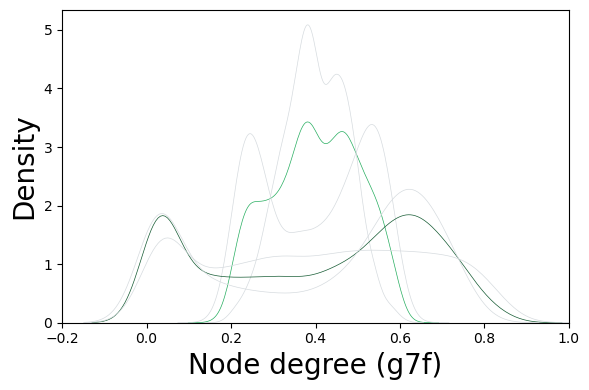

7021 3855 3166
7021 3855 3166


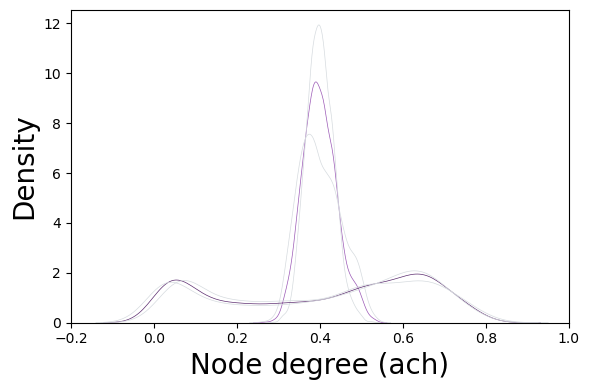

>>>> Testing between noise and denoise
------- G7f --------
ks_2samp stat: 0.2851445663010967  p value: 4.2014565865492654e-252
------- ACh --------
ks_2samp stat: 0.36362341546788207  p value: 0.0


In [6]:
fly_idx_list = ['20230420-fly2', '20230510-fly2']

## path
outpath = path_local + 'G7f-Ach_noise_ori_Stim/'

calc_degree_dist_noise = [] # 14
calc_degree_dist_denoise = [] # 14
ach_degree_dist_noise = [] # 14
ach_degree_dist_denoise = [] # 14

row = 10

for fly_idx in fly_idx_list:
    ## calc
    noise_input = path_inspur + 'Ach-' + fly_idx + '-noise-stimu/'
    data_df = pd.read_excel(noise_input + 'network_stat/region_66_network_stat.xlsx')
    dist =  data_df.iloc[row,1]
    calc_degree_dist_noise.append([float(i) for i in dist[1:-1].split(', ') if len(i) > 0])

    denoise_input = path_inspur + 'Ach-' + fly_idx + '-stimu/'
    data_df = pd.read_excel(denoise_input + 'network_stat/region_66_network_stat.xlsx')
    dist =  data_df.iloc[row,1]
    calc_degree_dist_denoise.append([float(i) for i in dist[1:-1].split(', ') if len(i) > 0])

    ## ach
    noise_input = path_inspur + 'Ach-' + fly_idx + '-noise-trans-stimu/'
    data_df = pd.read_excel(noise_input + 'network_stat/region_66_network_stat.xlsx')
    dist =  data_df.iloc[row,1]
    ach_degree_dist_noise.append([float(i) for i in dist[1:-1].split(', ') if len(i) > 0])

    denoise_input = path_inspur + 'Ach-' + fly_idx + '-trans-stimu/'
    data_df = pd.read_excel(denoise_input + 'network_stat/region_66_network_stat.xlsx')
    dist =  data_df.iloc[row,1]
    ach_degree_dist_denoise.append([float(i) for i in dist[1:-1].split(', ') if len(i) > 0])

## plot dist
calc_degree_dist_noise_fla = copy.deepcopy(calc_degree_dist_noise[0])
calc_degree_dist_noise_fla.extend(calc_degree_dist_noise[1])
calc_degree_dist_denoise_fla = copy.deepcopy(calc_degree_dist_denoise[0])
calc_degree_dist_denoise_fla.extend(calc_degree_dist_denoise[1])
plt.figure(figsize=(6,4), tight_layout = True)
ax = plt.subplot(1,1,1)
sns.kdeplot(calc_degree_dist_noise_fla, color = "#27AE60", linewidth = 0.5, cumulative = False, fill = False)
sns.kdeplot(calc_degree_dist_noise[0], color = "#D6DBDF", linewidth = 0.5, cumulative = False, fill = False)
sns.kdeplot(calc_degree_dist_noise[1], color = "#D6DBDF", linewidth = 0.5, cumulative = False, fill = False)
sns.kdeplot(calc_degree_dist_denoise_fla, color = "#145A32", linewidth = 0.5, cumulative = False, fill = False)
sns.kdeplot(calc_degree_dist_denoise[0], color = "#D6DBDF", linewidth = 0.5, cumulative = False, fill = False)
sns.kdeplot(calc_degree_dist_denoise[1], color = "#D6DBDF", linewidth = 0.5, cumulative = False, fill = False)
plt.ylabel("Density", fontsize = 20)
plt.xlabel("Node degree (g7f)", fontsize = 20)
plt.xlim(-0.2,1)
plt.savefig(outpath + 'both_fly_node_degree_central_noise_denoise_g7f.pdf', dpi = 300, bbox_inches='tight')
plt.show()

ach_degree_dist_noise_fla = copy.deepcopy(ach_degree_dist_noise[0])
ach_degree_dist_noise_fla.extend(ach_degree_dist_noise[1])
print(len(ach_degree_dist_noise_fla), len(ach_degree_dist_noise[0]), len(ach_degree_dist_noise[1]))
ach_degree_dist_denoise_fla = copy.deepcopy(ach_degree_dist_denoise[0])
ach_degree_dist_denoise_fla.extend(ach_degree_dist_denoise[1])
print(len(ach_degree_dist_denoise_fla), len(ach_degree_dist_denoise[0]), len(ach_degree_dist_denoise[1]))
plt.figure(figsize=(6,4), tight_layout = True)
ax = plt.subplot(1,1,1)
sns.kdeplot(ach_degree_dist_noise_fla, color = "#9B59B6", linewidth = 0.5, cumulative = False, fill = False)
sns.kdeplot(ach_degree_dist_noise[0], color = "#D6DBDF", linewidth = 0.5, cumulative = False, fill = False)
sns.kdeplot(ach_degree_dist_noise[1], color = "#D6DBDF", linewidth = 0.5, cumulative = False, fill = False)
sns.kdeplot(ach_degree_dist_denoise_fla, color = "#5B2C6F", linewidth = 0.5, cumulative = False, fill = False)
sns.kdeplot(ach_degree_dist_denoise[0], color = "#D6DBDF", linewidth = 0.5, cumulative = False, fill = False)
sns.kdeplot(ach_degree_dist_denoise[1], color = "#D6DBDF", linewidth = 0.5, cumulative = False, fill = False)
plt.ylabel("Density", fontsize = 20)
plt.xlabel("Node degree (ach)", fontsize = 20)
plt.xlim(-0.2,1)
plt.savefig(outpath + 'both_fly_node_degree_central_noise_denoise_ach.pdf', dpi = 300, bbox_inches='tight')
plt.show()


''' Test ''' 
alternative='less'
mode='auto'

print(">>>> Testing between noise and denoise")
print("------- G7f --------")
stat, p_vlaue = stats.ks_2samp(calc_degree_dist_noise_fla, calc_degree_dist_denoise_fla, alternative=alternative, mode=mode)
print("ks_2samp stat:", stat, " p value:", p_vlaue)
print("------- ACh --------")
stat, p_vlaue = stats.ks_2samp(ach_degree_dist_noise_fla, ach_degree_dist_denoise_fla, alternative=alternative, mode=mode)
print("ks_2samp stat:", stat, " p value:", p_vlaue)

